In [1]:
import numpy as np
from sklearn.datasets import make_regression
from scipy.spatial.distance import norm
from itertools import product
from collections import OrderedDict
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
import time

tls.set_credentials_file(username='', api_key='')

def gradient_descent(X, y, 
                     cost_function, # The cost function from which we'll calculate the cost. 
                     gradient_of_cost_function, # The function that we'll use to calculate the gradient. 
                     initial_guess, # Our initial parameters.
                     learning_rate=.1, # This is the step size.
                     threshold=1e-3, # When the gradient gets this flat, stop.
                     max_iter=1e3): # How may times we're willing to take a step.
    
    
    params = initial_guess
        # We keep track of the previous parameters. We store a tuple with our initial guess
        # and the cost. The number of parameters is hard coded to be 2. This is
        # not a general purpose gradient descent function. We will be returning the 
        # the parameter history, not just the final parameters. This is so that we can
        # compare how well this version of gradient descent converges compared to other 
        # versions.
    param_history = [(initial_guess[0], initial_guess[1], cost_function(X, y, params))]
        # improvement = (cost_old-cost_new)/cost_old. This may not make sense if the is ever
        # close to zero. The function doesn't actually use this parameter.
    improvement = threshold
        # Start the cost at something high so that it can only get smaller. Probably
        # better to start it at float('inf')
    old_cost = 100000
        # The starting value for our index.
    iterations = 0
        # We keep track of how long each iteration takes. 
    initial_time = time.time()
    time_history = []
    #time_history = [time.time()]
        # When the gradient is big, keep descending. However, if the number of iterations
        # becomes equal to the maximum number, max_iter, stop. This prevents us from getting
        # stuck in an infinite loop.
    
    while (norm(gradient_of_cost_function(X, y, params)) >= threshold 
           and iterations < max_iter):
        iterations += 1
            # Here we calculate the step size and store it in params.
        params -= learning_rate*gradient_of_cost_function(X, y, params)
            # We calculate the current cost and store it in a temporary variable.
        cost = cost_function(X, y, params)
            # Because this next line uses params[0] and params[1], we know that this funtion
            # is hard coded to do gradient descent with two parameters. 
            # We will eventually be graphing time vs cost.
        param_history.append((params[0], params[1], cost)) # for plotting
            # This is how much the cost function improved compared to previously.
            # There could be a problem if the old cost is zero. But in linear regression, 
            # the cost is strictly positive. 
        improvement = np.abs(cost - old_cost)/old_cost
            # update the old cost to be the current one for the next iteration.
        old_cost = cost
            # keep track of the time at which this iteration happened. This is for graphing.
        #time_history.append(time.time())
        time_history.append(time.time()-initial_time)
        
        # This next couple of lines just tells us if we reached the maximum number of iterations.
        # If we did, print it. This is important because in this case we may not have actually
        # reached a solution.
    if iterations == max_iter:
        print "max iterations reached"
    print "Final gradient of cost function %s" %gradient_of_cost_function(X, y, params)
    print "Final params %s" %params
    
        # We return not just the parameters, but the history of parameters.
    return param_history, time_history


def stochastic_gradient_descent(X, y, 
                     cost_function, # The cost function
                     gradient_of_cost_function, # The gradient cost function.
                     initial_guess, # Our initial guess for the answer. 
                     learning_rate=.1, # The step size. 
                     threshold=1e-3, # If the gradient is flatter than this, stop.
                     max_iter=1e3, # If we step more than this number of times, stop.
                     batch_size=1): # The number of data points used to calculate the gradient.
    
        # We can't have a batch size that is bigger than the number of data point. We check for this
        # in the next line. 
    batch_size = min(batch_size, X.shape[0])
        # Relabeling our parameters. 
    params = initial_guess
        # The gradient descent function above also kept track of the cost function. 
        # The function returns param_history.
    param_history = [(initial_guess[0], initial_guess[1])]
        # improvement = (cost_new - cost_old)/cost_old
    improvement = threshold
        # the initial cost. This is rather arbitrary. I would choose it to be float('inf')
    old_cost = 100000
        # We keep track of how many times we have gone through our loop with the iterations
        # variable. We will add one to it every time we go through the while loop.
    iterations = 0
        # We clock our initial time. We will return this list. 
    #time_history = [time.time()]
    initial_time = time.time()
    time_history = []
    
        # When the gradient is steep enough and we haven't reached our threshold for
        # how many iterations we're willing to do, then go down the hill.
    while (norm(gradient_of_cost_function(X, y, params)) >= threshold 
           and iterations < max_iter):
        # select indices of mini-batch
            # I am not really sure what this does yet.
            # If the iteration is zero, then the min_index is zero. If iteration=1, then the 
            # min_index = batch_size. So what we are doing is splitting the data into groups.
            # They are not random groups though. 
        min_index = batch_size*iterations % X.shape[0]
        indices = []
            # Fill up the indices for the next batch.
        while len(indices) < batch_size:
            indices.append((min_index + len(indices)) % X.shape[0])
        Xi, yi = X[indices], y[indices]
        # update parameters
        params -= learning_rate*gradient_of_cost_function(Xi, yi, params)
        cost = cost_function(Xi, yi, params)
        param_history.append((params[0], params[1])) # for plotting
        improvement = np.abs(cost - old_cost)/old_cost
        old_cost = cost
        iterations += 1
        time_history.append(time.time()-initial_time)
    if iterations == max_iter:
        print "max iterations reached"
    print "Final gradient of cost function %s" %gradient_of_cost_function(X, y, params)
    print "Final params %s" %params
    return param_history, time_history

In [2]:
def plot_results(X, y, cost_function, param_history):
    params = param_history[-1][0:2]
    x_params = np.array([params[0] - (params[0]-p[0]) for p in param_history] +
                [params[0] + (params[0]-p[0]) for p in param_history])
    x_params.sort()
    y_params = np.array([params[1] - (params[1]-p[1]) for p in param_history] +
                [params[1] + (params[1]-p[1]) for p in param_history])
    y_params.sort()
    samples = list(product(x_params, y_params))
    costs = [cost_function(X, y, np.array([p[0], p[1]])) for p in samples]
    costs = np.reshape(costs, (len(x_params), -1))
    cost_surface = Surface(
        x = x_params,
        y = y_params,
        z = costs,
        colorscale = [[0, 'rgb(31,119,180)'], 
                      [0.5, 'rgb(143, 123, 196)'], 
                      [1, 'rgb(255,127,97)']],
        name='Cost Function'
    )
    param_history = Scatter3d(
        x = x_params,
        y = y_params,
        z = [p[2] for p in param_history],
        mode = 'lines+markers'
    )
    data_3d_plot = Data([cost_surface, param_history])
    figure_3d = Figure(data=data_3d_plot)
    return figure_3d

def plot_sgd_results(X, y, cost_function, param_history):
    x_history = [p[0] for p in param_history]
    y_history = [p[1] for p in param_history]
    x_params = np.linspace(min(x_history),
                           max(x_history),
                           100)
    y_params = np.linspace(min(y_history),
                           max(y_history),
                           100)
    samples = list(product(x_params, y_params))
    demo_points = OrderedDict()
    for p in param_history:
        best_sample = samples[0]
        min_distance = ((p[0]-best_sample[0])**2+(p[1]-best_sample[1])**2)**.5
        for sample in samples:
            d = ((p[0]-sample[0])**2+(p[1]-sample[1])**2)**.5
            if d < min_distance:
                best_sample = sample
                min_distance = d
        demo_points[tuple(p)] = best_sample
    costs = [cost_function(X, y, np.array([p[0], p[1]])) for p in samples]
    costs = np.reshape(costs, (len(x_params), -1))
    cost_surface = Surface(
        x = x_params,
        y = y_params,
        z = costs,
        colorscale = [[0, 'rgb(31,119,180)'], 
                      [0.5, 'rgb(143, 123, 196)'], 
                      [1, 'rgb(255,127,97)']],
        name='Cost Function'
    )
    param_history = Scatter3d(
        x = [d[0] for d in demo_points],
        y = [d[1] for d in demo_points],
        z = [cost_function(X, y, d) for d in demo_points],
        mode = 'lines+markers'
    )
    data_3d_plot = Data([cost_surface, param_history])
    figure_3d = Figure(data=data_3d_plot)
    return figure_3d

In [3]:
def predict(X, params):
    y_predicted = X.dot(params)
    return y_predicted

    # make_regression is a sub-module from sklearn. We're using it to generate data. 
X, y = make_regression(n_samples = 50, n_features = 2, n_informative=2, random_state=0)

    # The next line normalizes the data.
X = (X - X.mean(axis=0))/X.std()





Next we plot the data in a 3-d graph. 

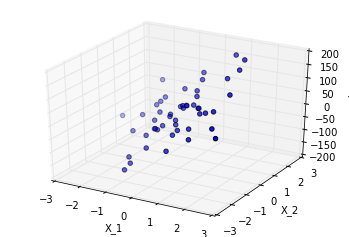

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = X[:,0]
ys = X[:,1]
zs = y
ax.scatter(xs, ys, zs, c='b')

ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Y')

plt.show()

Here we do gradient descent on the half average sum of squares cost function, RSS/(2n)
The graph is of both the cost function and a history of parameters.

Final gradient of cost function [-0.00036218 -0.00086667]
Final params [ 42.71922179  61.1163727 ]


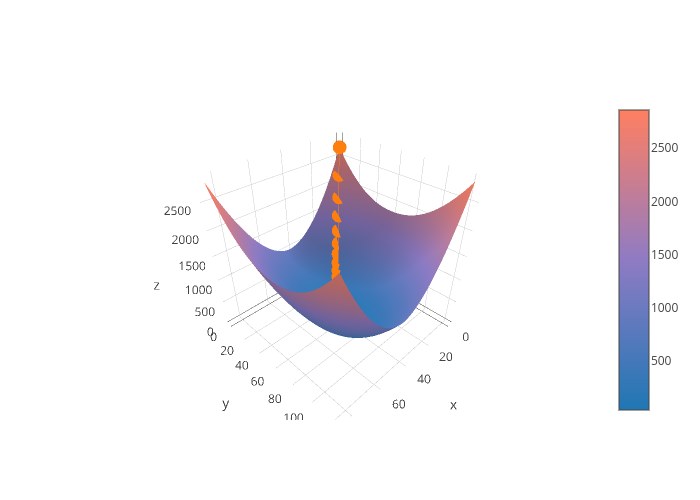

In [5]:
# LINEAR REGRESSION WITHOUT REGULARIZATION

def ols_cost_function(X, y, params):
    '''
    OLS from linear regression
    '''
        # Get the number of rows in our data.
    n_observations = X.shape[0]
        # Average square of the residual. RSS/n. I don't understand why the extra factor of 2?
        # I think it is over 2 so that the gradient has no factor of two. So this is really
        # half of the average of the residuals. 
    avg_squared_residuals = ((predict(X, params) - y)**2).sum()/(2*n_observations)
    return avg_squared_residuals

def ols_gradient_of_cost_function(X, y, params):
        # The number of rows in our data. 
    n_observations = X.shape[0]
        # The gradient of the RSS/(2n) cost function.
    gradient = (predict(X, params) - y).dot(X)/n_observations
    return gradient


print "Here we do gradient descent on the half average sum of squares cost function, RSS/(2n)"
print "The graph is of both the cost function and a history of parameters.\n"

gd_param_history, gd_time_history = gradient_descent(X, y, 
                                                     ols_cost_function, 
                                                     ols_gradient_of_cost_function,
                                                     initial_guess = np.array([0., 0.]))


figure_3d = plot_results(X, y, ols_cost_function, gd_param_history)
tls.embed(py.plot(figure_3d))



Here we do gradient descent on the ridge regression cost function.
This is essentially the average sum of squares $+ \lambda \beta \cdot eta$
The parameters are slightly smaller, by 2 or 3.


Final gradient of cost function [-0.00037271 -0.00087987]
Final params [ 41.06629797  58.59902384]


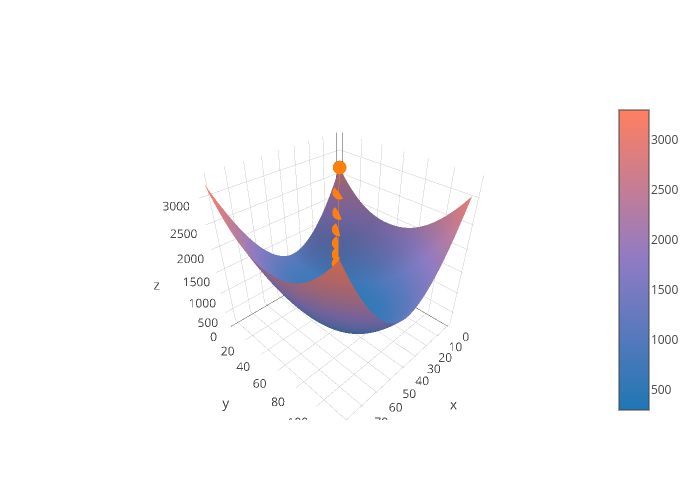

In [6]:
# LINEAR REGRESSION WITH L2 REGULARIZATION

def ridge_cost_function(X, y, params, lambda_=5.):
    '''
    OLS from linear regression
    '''
    n_observations = X.shape[0]
    avg_squared_residuals = (((predict(X, params) - y)**2).sum()
                             + lambda_*(params**2).sum())/(2*n_observations)
    return avg_squared_residuals

def ridge_gradient_of_cost_function(X, y, params, lambda_=2.):
    n_observations = X.shape[0]
    gradient = ((predict(X, params) - y).dot(X)
               + lambda_*params)/n_observations
    return gradient

print "Here we do gradient descent on the ridge regression cost function."
print "This is essentially the average sum of squares $+ \lambda \\beta \cdot \beta$"
print "The parameters are slightly smaller, by 2 or 3."
print "\n"


ridge_param_history, ridge_time_history = gradient_descent(X, y, ridge_cost_function, ridge_gradient_of_cost_function,
                                   initial_guess = np.array([0., 0.]))

figure_3d = plot_results(X, y, ridge_cost_function, ridge_param_history)
tls.embed(py.plot(figure_3d))


Here we show the cost function for Lasso. This is like the average sum of squares with
an additional piece to the cost function that penalizes bigger coefficeints. This is
much like ridge regression but the cost is the sum of the absolute values of each of the
coefficients. The result of the sum of absolute values is that the cost function is not
longer differentiable everywhere. In particular, the gradient changes abruptly when
$eta_1 = 0$ or $eta_2=0$. Because of this one has to be careful about how one defines
the gradient at these points.


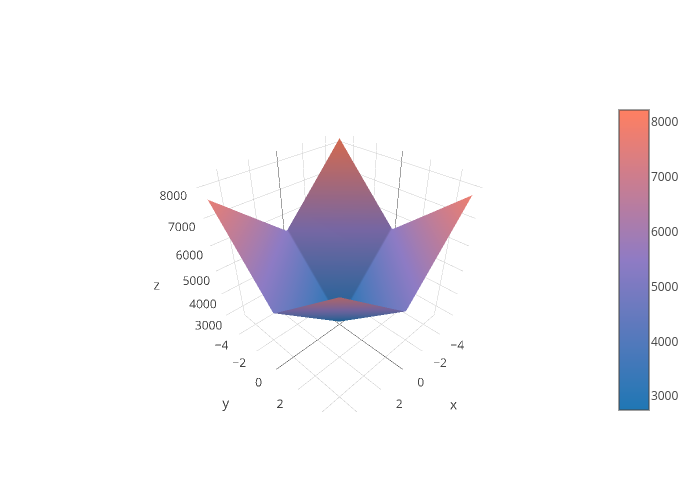

In [7]:
# LASSO
PARAM_HISTORY = [] 

LAMBDA_ = 50000.

def lasso_cost_function(X, y, params, lambda_=LAMBDA_):
    '''
    OLS from linear regression
    '''
    n_observations = X.shape[0]
    avg_squared_residuals = (((predict(X, params) - y)**2).sum()
                             + lambda_*sum(np.abs(params)))/(2*n_observations)
    return avg_squared_residuals

x_params = np.linspace(-5, 5, 100)
y_params = np.linspace(-5, 5, 100)
samples = list(product(x_params, y_params))
costs = [lasso_cost_function(X, y, np.array([p[0], p[1]])) for p in samples]
costs = np.reshape(costs, (len(x_params), -1))
cost_surface = Surface(
    z = costs,
    x = x_params,
    y = y_params,
    colorscale = [[0, 'rgb(31,119,180)'], 
                  [0.5, 'rgb(143, 123, 196)'], 
                  [1, 'rgb(255,127,97)']],
    name='Cost Function'
)

print "Here we show the cost function for Lasso. This is like the average sum of squares with"
print "an additional piece to the cost function that penalizes bigger coefficeints. This is"
print "much like ridge regression but the cost is the sum of the absolute values of each of the"
print "coefficients. The result of the sum of absolute values is that the cost function is not"
print "longer differentiable everywhere. In particular, the gradient changes abruptly when"
print "$\beta_1 = 0$ or $\beta_2=0$. Because of this one has to be careful about how one defines"
print "the gradient at these points."

data_3d_plot = Data([cost_surface])
figure_3d = Figure(data=data_3d_plot)
tls.embed(py.plot(figure_3d))


Here we do stochastic gradient descent. By default the batch size is 1. That is, we
calculate the gradient from an individual data point. We plot the path that the
parameters take. 

max iterations reached
Final gradient of cost function [-1.33573467  0.45502579]
Final params [ 41.45343437  61.55137444]


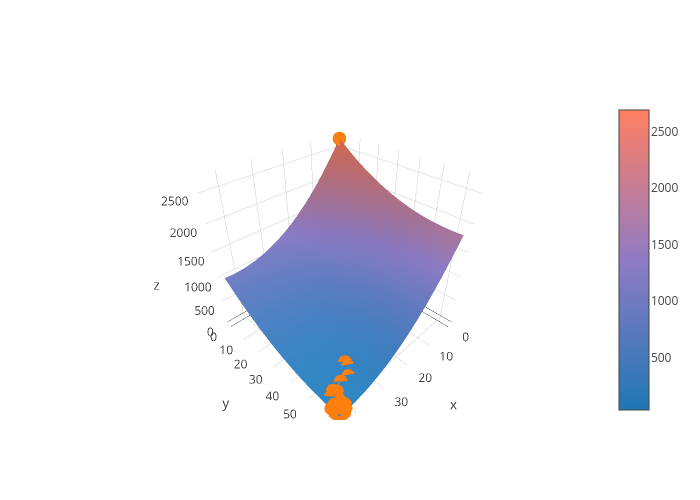

In [8]:
# SGD: LINEAR REGRESSION

print "Here we do stochastic gradient descent. By default the batch size is 1. That is, we"
print "calculate the gradient from an individual data point. We plot the path that the"
print "parameters take. \n"

    # The next line runs the stochastic gradient descent algorith.
sgd_param_history, sgd_time_history = stochastic_gradient_descent(X, y, 
                                                            ols_cost_function, 
                                                            ols_gradient_of_cost_function,
                                                            initial_guess=np.array([0., 0.]),
                                                            learning_rate=.1)

    # The next lines plot the results of stochastic gradient descent. 
figure_3d = plot_sgd_results(X, y, ols_cost_function, sgd_param_history)
tls.embed(py.plot(figure_3d))


Next we do mini-batch stochastic gradient descent for the average sum of squares cost function. Notice that the approach is much smoother. 

max iterations reached
Final gradient of cost function [-0.07039159  0.12712869]
Final params [ 42.65627649  61.24856424]


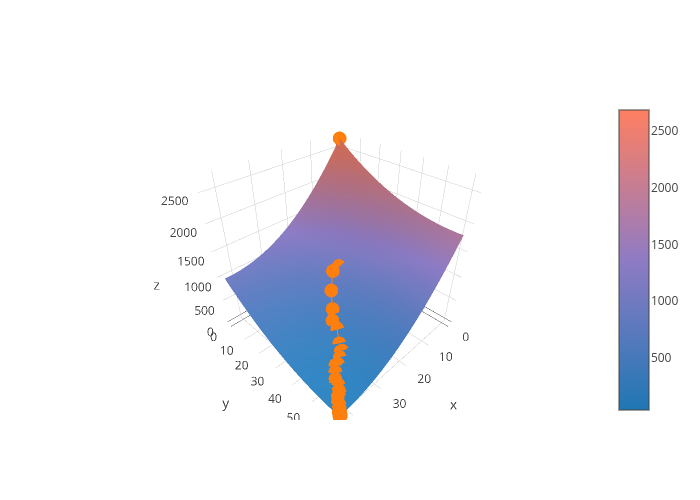

In [9]:
# MINIBATCH SGD: LINEAR REGRESSION WITHOUT REGULARIZATION
minibatch_param_history, minibatch_time_history = stochastic_gradient_descent(X, y, ols_cost_function, 
                                                ols_gradient_of_cost_function,
                                                initial_guess=np.array([0., 0.]),
                                                learning_rate=.1, batch_size=5)
figure_3d = plot_sgd_results(X, y, ols_cost_function, minibatch_param_history)
tls.embed(py.plot(figure_3d))

We are plotting step vs log(Cost)


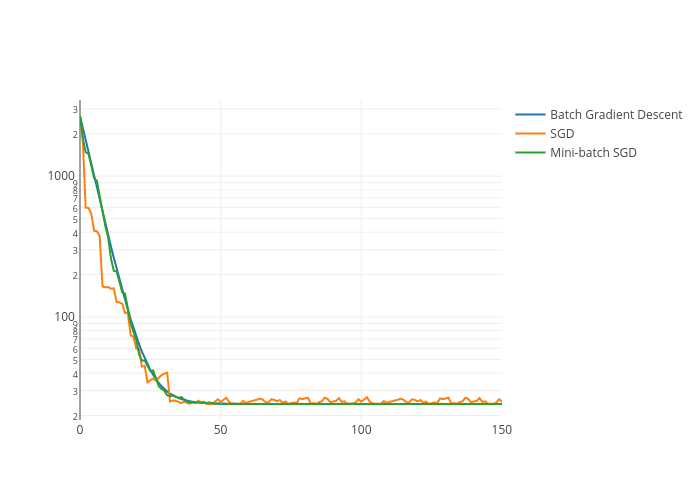

In [10]:
# PLOT GD, SGD, and minibatch SGD convergence on log scale
gd_convergence = Scatter(
    x = [i for i,j in enumerate(gd_param_history)],
    y = [ols_cost_function(X, y, (p[0], p[1])) for p in gd_param_history],
    mode = 'lines',
    name = 'Batch Gradient Descent'
)

sgd_convergence = Scatter(
    x = [i for i,j in enumerate(sgd_param_history)],
    y = [ols_cost_function(X, y, (p[0], p[1])) for p in sgd_param_history],
    mode = 'lines',
    name = 'SGD'
)

minibatch_convergence = Scatter(
    x = [i for i,j in enumerate(minibatch_param_history)],
    y = [ols_cost_function(X, y, (p[0], p[1])) for p in minibatch_param_history],
    mode = 'lines',
    name = 'Mini-batch SGD'
)

layout = Layout(
    xaxis=XAxis(
        range=[0,150]
    ),
    yaxis=YAxis(
        type='log',
        autorange=True,
    )
)

print "We are plotting step vs log(Cost)"

data = Data([gd_convergence, sgd_convergence, minibatch_convergence])
figure = Figure(data=data, layout=layout)
tls.embed(py.plot(figure))

We are plotting step vs log(Cost)


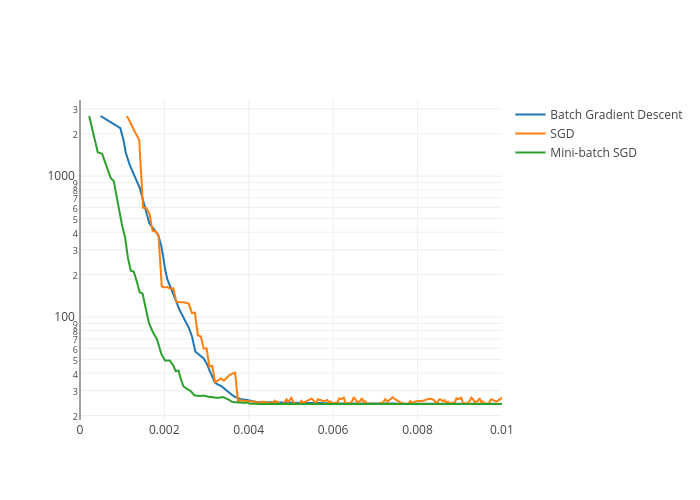

In [11]:
# PLOT GD, SGD, and minibatch SGD convergence on log scale now with the cpu times. 

    # start each computation at zero. This may not be valid as the initial time was computed
    # for each one. So subtracting the first entry from everything may not be valid. 
#gd_time_history = np.array(gd_time_history)-gd_time_history[0]
#sgd_time_history = np.array(sgd_time_history)-sgd_time_history[0]
#minibatch_time_history = np.array(minibatch_time_history) - minibatch_time_history[0]

gd_convergence = Scatter(
    x = gd_time_history,
    y = [ols_cost_function(X, y, (p[0], p[1])) for p in gd_param_history],
    mode = 'lines',
    name = 'Batch Gradient Descent'
)

sgd_convergence = Scatter(
    x = sgd_time_history,
    y = [ols_cost_function(X, y, (p[0], p[1])) for p in sgd_param_history],
    mode = 'lines',
    name = 'SGD'
)

minibatch_convergence = Scatter(
    x = minibatch_time_history,
    y = [ols_cost_function(X, y, (p[0], p[1])) for p in minibatch_param_history],
    mode = 'lines',
    name = 'Mini-batch SGD'
)

layout = Layout(
    xaxis=XAxis(
        range=[0,.01]
    ),
    yaxis=YAxis(
        type='log',
        autorange=True,
    )
)

print "We are plotting step vs log(Cost)"

data = Data([gd_convergence, sgd_convergence, minibatch_convergence])
figure = Figure(data=data, layout=layout)
tls.embed(py.plot(figure))


In [12]:
gd_time_history[0],sgd_time_history[0],minibatch_time_history[0]

(0.0004870891571044922, 0.0011119842529296875, 0.00021696090698242188)